In [1]:
## Importing Modules
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall,Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
images = []
labels =[]
for sub_dir in os.listdir('/kaggle/input/fractureclassification/fracture'):
  image_list=os.listdir(os.path.join('/kaggle/input/fractureclassification/fracture',sub_dir))  #list of all image names in the directory
  image_list = list(map(lambda x:os.path.join(sub_dir,x),image_list))
  images.extend(image_list)
  labels.extend([sub_dir]*len(image_list))

In [3]:
import pandas as pd
df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # To shuffle the data 
df_train = df.head(20000)
df_test = df.tail(2926)
print(df_train)

                                    Images         Labels
0      Non_fractured/aug_00_IMG0002811.jpg  Non_fractured
1      Non_fractured/aug_04_IMG0001293.jpg  Non_fractured
2      Non_fractured/aug_01_IMG0002616.jpg  Non_fractured
3          Fractured/aug_01_IMG0002610.jpg      Fractured
4      Non_fractured/aug_03_IMG0001915.jpg  Non_fractured
...                                    ...            ...
19995  Non_fractured/aug_03_IMG0003124.jpg  Non_fractured
19996  Non_fractured/aug_05_IMG0003497.jpg  Non_fractured
19997  Non_fractured/aug_01_IMG0000755.jpg  Non_fractured
19998  Non_fractured/aug_04_IMG0002104.jpg  Non_fractured
19999  Non_fractured/aug_03_IMG0000719.jpg  Non_fractured

[20000 rows x 2 columns]


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory='/kaggle/input/fractureclassification/fracture',
x_col="Images",
y_col="Labels",
subset='training',
batch_size=8,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(288,288))



validation_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory='/kaggle/input/fractureclassification/fracture',
x_col="Images",
y_col="Labels",
subset='validation',
batch_size=8,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(288,288))

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [5]:
def mkfe(inputs):
    """ First Stream """
    x1 = DepthwiseConv2D(3, strides=(1, 1), depth_multiplier=1, padding='same', use_bias=False)(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    s1 = Activation("relu")(x1)

    """ Second Stream """
    x2 = DepthwiseConv2D(5, strides=(1, 1), depth_multiplier=1, padding='same', use_bias=False)(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    s2 = Activation("relu")(x2)
    
    """ third Stream """
    x3 = DepthwiseConv2D(7, strides=(1, 1), depth_multiplier=1, padding='same', use_bias=False)(inputs)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    x3 = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x3)
    x3 = BatchNormalization()(x3)
    s3 = Activation("relu")(x3)

    add = Concatenate()([s1, s2, s3])
    x = Conv2D(add.shape[-1], (1, 1), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x+add)
    return x

In [6]:
""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization()(y_pool)
    y_pool = Activation('relu')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)
    y_6 = mkfe(y_6)
    
    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)
    y_12 = mkfe(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)
    y_18 = mkfe(y_18)
    
    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [7]:
from keras.applications import DenseNet121
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
# Load the pre-trained DenseNet model (without top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(288, 288, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a functional model by adding custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Assuming 10 classes for classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [8]:
def build_model(num_classes):
    IMG_SIZE = 288
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    """ Encoder """
    en = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=inputs)
    for layer in en.layers:
        layer.trainable = False
    x = en.output
    x = ASPP(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

  
    
    o = Dense(num_classes, activation="softmax", name="pred")(x)
    
    model = tf.keras.Model(inputs, o, name="XHDGD")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=['Accuracy',Precision(),Recall()]
    )
    return model

In [9]:
model = build_model(num_classes=2)

In [10]:
model.summary()

Model: "XHDGD"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 288, 288, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 294, 294, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 144, 144, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 144, 144, 64)         256       ['conv1/conv[0][0]']      

In [11]:
epochs = 25
hist = model.fit_generator( generator=train_generator,
                            validation_data=validation_generator,
                            epochs=epochs,
                            steps_per_epoch=(16000//8),
                            validation_steps=(4000//8),
                            verbose=1
)

/tmp/ipykernel_42/4029156550.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator( generator=train_generator,


Epoch 1/25
2000/2000 [==============================] - 173s 72ms/step - loss: 0.3391 - Accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - val_loss: 0.3035 - val_Accuracy: 0.8740 - val_precision: 0.8740 - val_recall: 0.8740
Epoch 2/25
2000/2000 [==============================] - 142s 71ms/step - loss: 0.2286 - Accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - val_loss: 0.2609 - val_Accuracy: 0.9093 - val_precision: 0.9093 - val_recall: 0.9093
Epoch 3/25
2000/2000 [==============================] - 141s 71ms/step - loss: 0.1617 - Accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - val_loss: 0.2310 - val_Accuracy: 0.9130 - val_precision: 0.9130 - val_recall: 0.9130
Epoch 4/25
2000/2000 [==============================] - 142s 71ms/step - loss: 0.1029 - Accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - val_loss: 0.3463 - val_Accuracy: 0.9050 - val_precision: 0.9050 - val_recall: 0.9050
Epoch 5/25
2000/2000 [==============================] - 141s 70ms/step - loss: 0.074

In [12]:
score = model.evaluate(validation_generator, verbose = 1) 
print('Validation loss:', score[0]) 
print('Validation accuracy:', score[1])

500/500 [==============================] - 22s 44ms/step - loss: 0.4923 - Accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258
Validation loss: 0.4922604560852051
Validation accuracy: 0.9257500171661377


In [13]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    )

test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory='/kaggle/input/fractureclassification/fracture',
x_col="Images",
y_col="Labels",
batch_size=8,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(288,288))

Found 2926 validated image filenames belonging to 2 classes.


In [14]:
test_score = model.evaluate(test_generator, verbose = 1) 
print('Test loss:', test_score[0]) 
print('Test accuracy:', test_score[1])

366/366 [==============================] - 18s 50ms/step - loss: 0.4875 - Accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224
Test loss: 0.4874725341796875
Test accuracy: 0.9224196672439575


In [15]:
target_names = []

for key in train_generator.class_indices:
    target_names.append(key)
    
print(target_names)

['Fractured', 'Non_fractured']


In [16]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(11, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)  # Replace NaN values with zero
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontdict={'size': 16})
    plt.xlabel('Predicted label', fontdict={'size': 16})
    plt.savefig('/kaggle/working/confusion_modmob.jpg')
    plt.tight_layout()

366/366 [==============================] - 17s 40ms/step
Confusion Matrix
Confusion matrix, without normalization


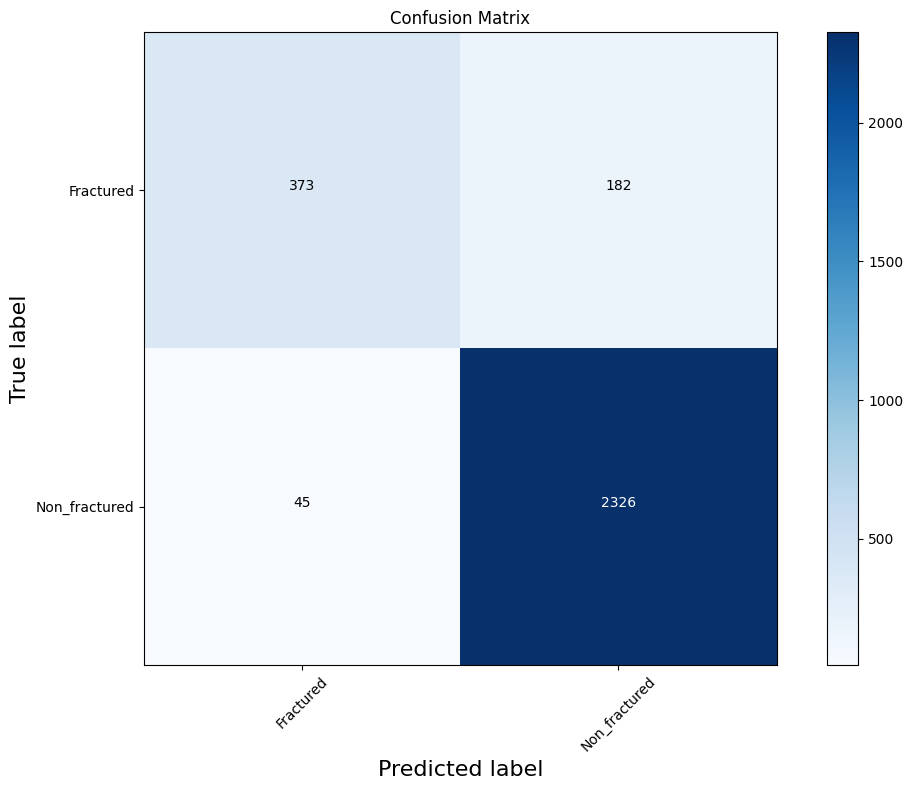

In [17]:
import itertools
from sklearn.metrics import confusion_matrix,classification_report
Y_pred = model.predict(test_generator,batch_size=8)
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', normalize=False)

In [18]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
               precision    recall  f1-score   support

    Fractured       0.89      0.67      0.77       555
Non_fractured       0.93      0.98      0.95      2371

     accuracy                           0.92      2926
    macro avg       0.91      0.83      0.86      2926
 weighted avg       0.92      0.92      0.92      2926



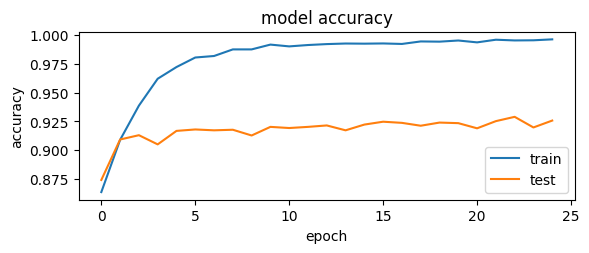

In [20]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(hist.history['Accuracy'])
plot.plot(hist.history['val_Accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plt.savefig('/kaggle/working/accuracymodmob_FracAtlas.png')
plot.legend(['train', 'test'], loc='lower right')

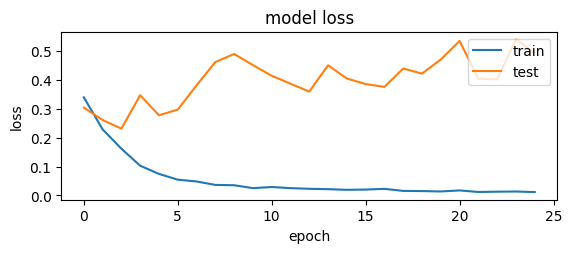

In [21]:
plot.subplot(2,1,2)
plot.plot(hist.history['loss'])
plot.plot(hist.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plt.savefig('/kaggle/working/lossmodmob_FracAtlas.png')
plot.legend(['train', 'test'], loc='upper right')

In [22]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}
filenames = test_generator.filenames

In [23]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = test_generator.classes
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False

/tmp/ipykernel_42/1201255221.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [25]:
val_df.head(10)

,filename,actual,predicted,Same
0,Non_fractured/aug_01_IMG0001792.jpg,Non_fractured,Non_fractured,True
1,Non_fractured/aug_04_IMG0002976.jpg,Non_fractured,Non_fractured,True
2,Fractured/aug_04_IMG0002646.jpg,Fractured,Fractured,True
3,Fractured/aug_01_IMG0002578.jpg,Fractured,Fractured,True
4,Non_fractured/aug_02_IMG0002687.jpg,Non_fractured,Non_fractured,True
5,Non_fractured/aug_02_IMG0004118.jpg,Non_fractured,Non_fractured,True
6,Non_fractured/aug_01_IMG0002770.jpg,Non_fractured,Non_fractured,True
7,Non_fractured/aug_02_IMG0002066.jpg,Non_fractured,Non_fractured,True
8,Non_fractured/aug_01_IMG0000878.jpg,Non_fractured,Non_fractured,True
9,Fractured/aug_05_IMG0002181.jpg,Fractured,Non_fractured,False


In [26]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(288,288))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (25 , 25))
    n = 0
    for i in range(9):
        n+=1
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"/kaggle/input/fractureclassification/fracture/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

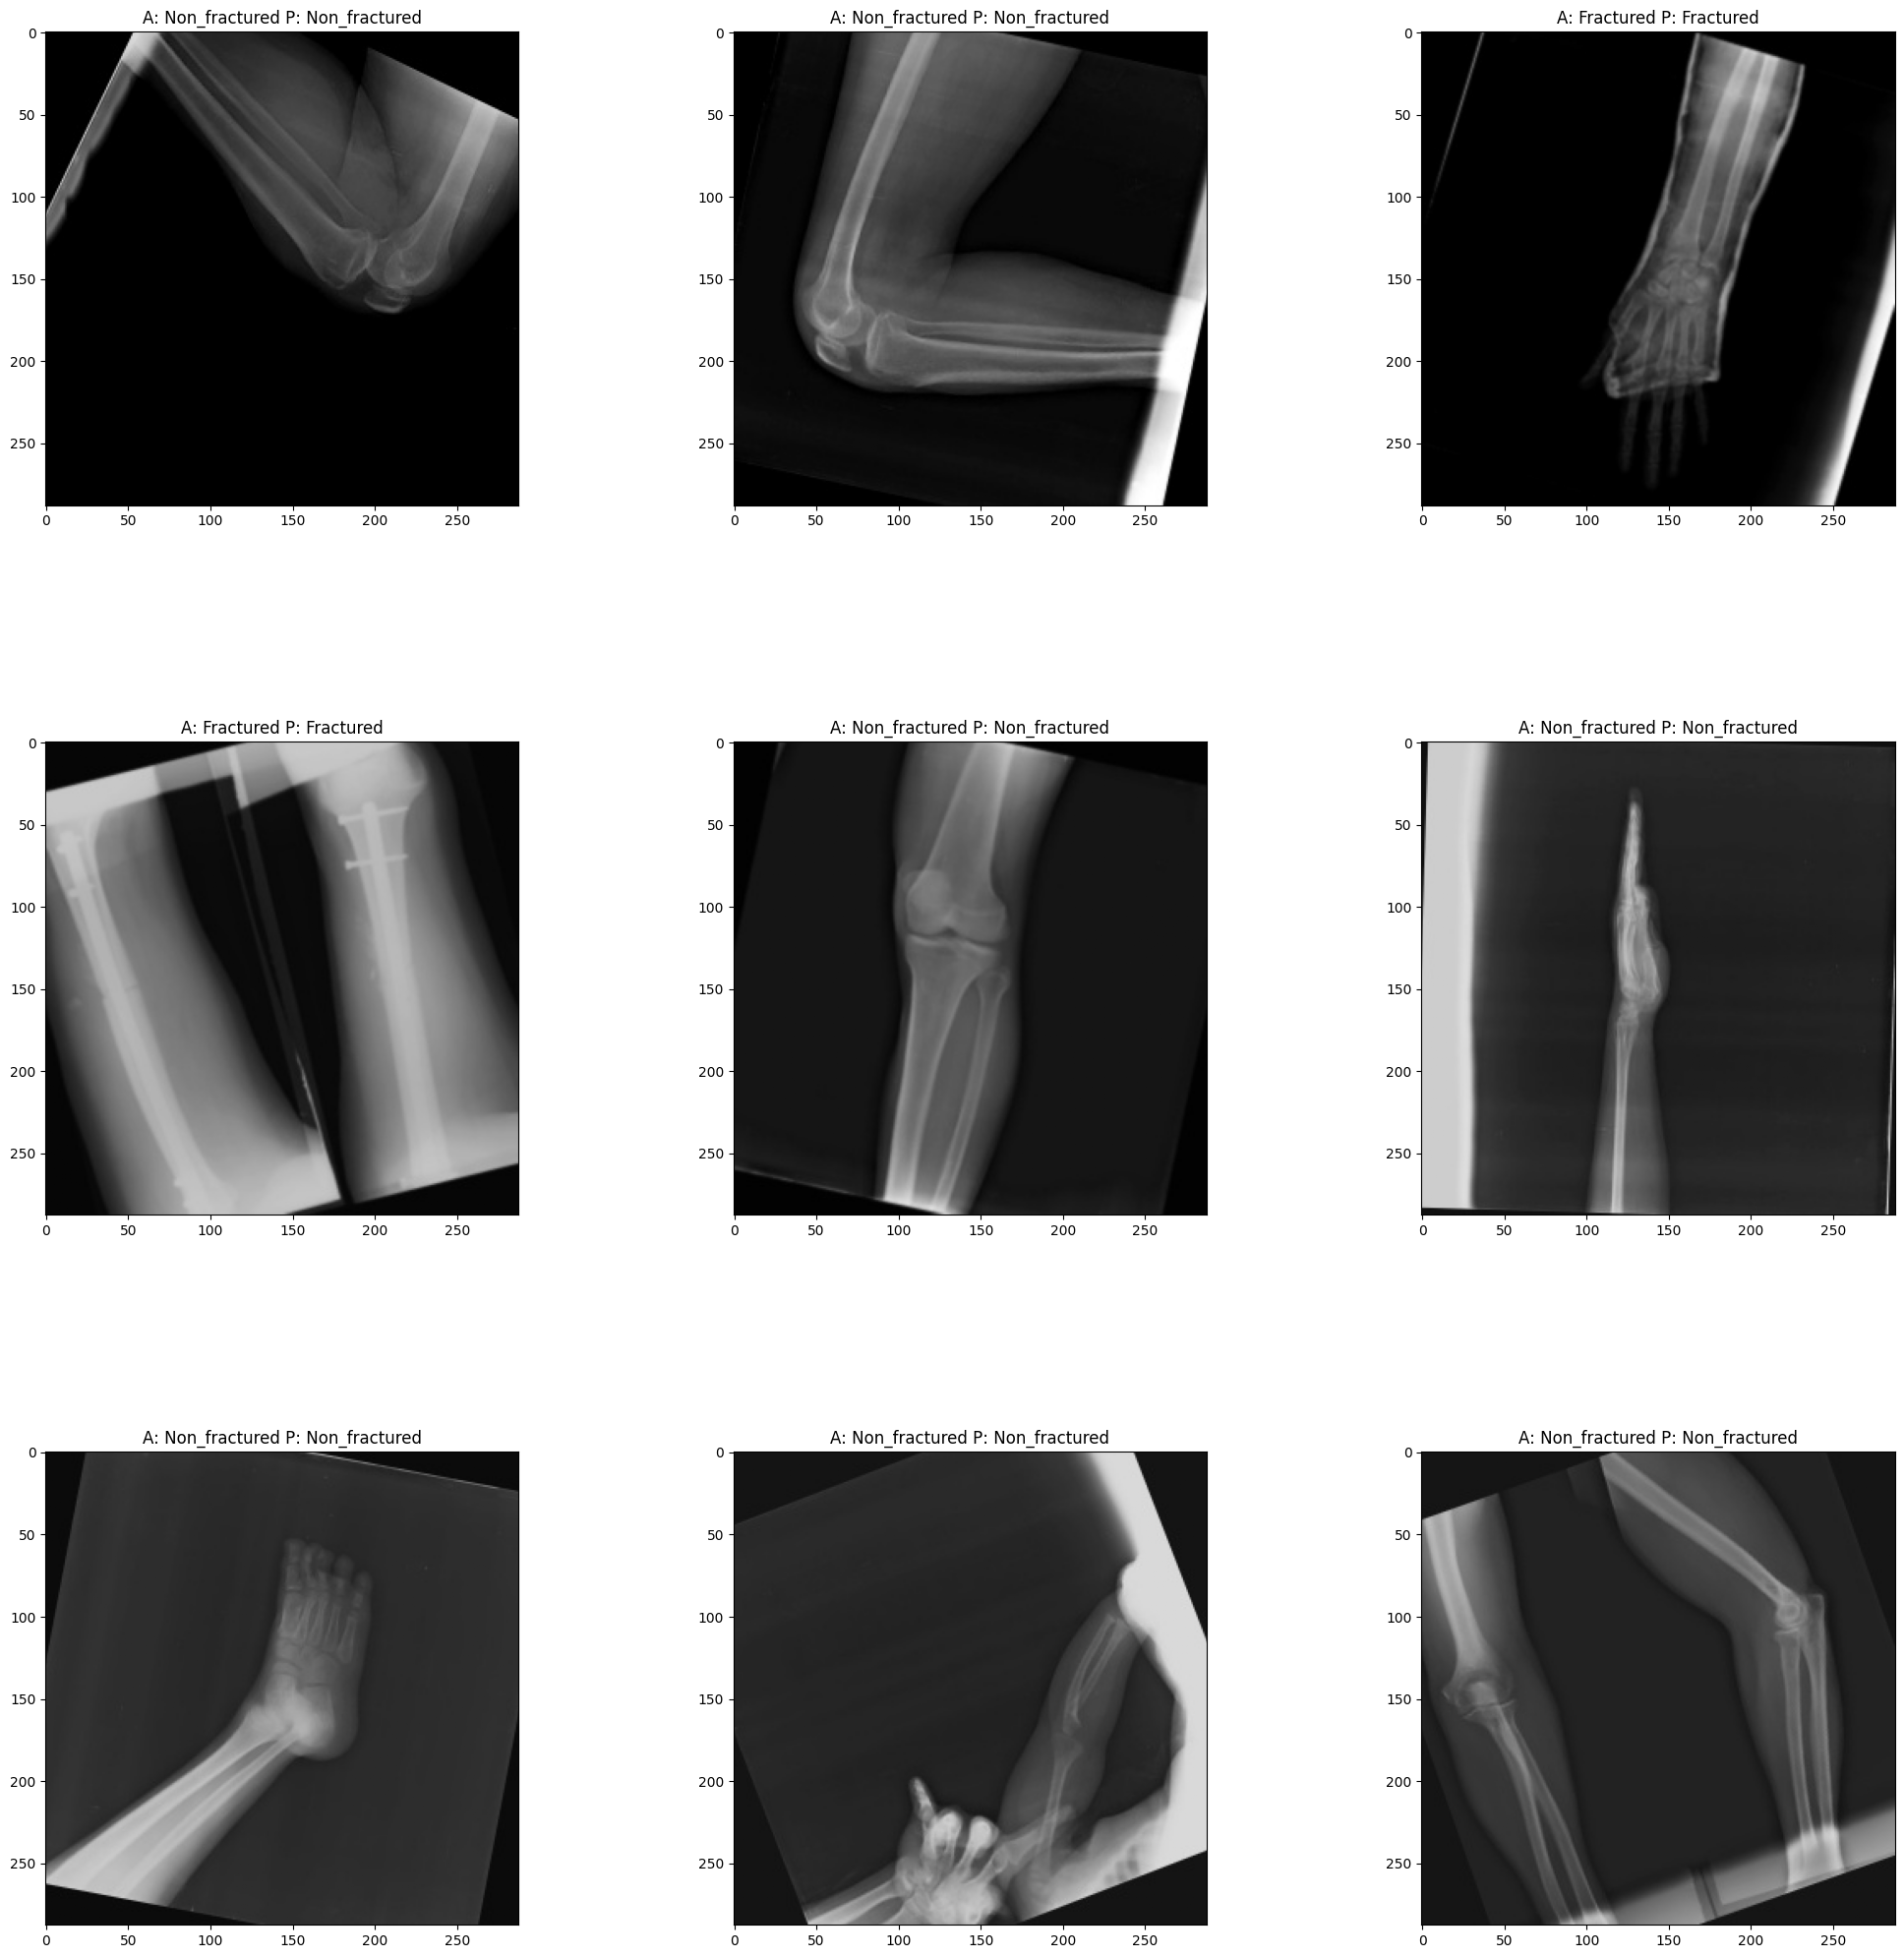

In [34]:
display_images(val_df[val_df['Same']==True])

In [35]:
model.save('trained_fracture_classification_model.keras')

In [36]:
hist.history #Return Dictionary of history

{'loss': [0.3391185998916626,
  0.22855646908283234,
  0.1616743505001068,
  0.1028725877404213,
  0.07458464801311493,
  0.054677680134773254,
  0.048454463481903076,
  0.03657742589712143,
  0.03543996810913086,
  0.025471385568380356,
  0.029304534196853638,
  0.025449702516198158,
  0.023228831589221954,
  0.021765051409602165,
  0.019638264551758766,
  0.02045919932425022,
  0.02294580452144146,
  0.015868794173002243,
  0.015280085615813732,
  0.013930761255323887,
  0.017504291608929634,
  0.012187894433736801,
  0.013164251111447811,
  0.013805665075778961,
  0.011793334037065506],
 'Accuracy': [0.8634374737739563,
  0.9089375138282776,
  0.9387500286102295,
  0.9621875286102295,
  0.9723749756813049,
  0.9806874990463257,
  0.9819999933242798,
  0.9877499938011169,
  0.9877499938011169,
  0.991937518119812,
  0.9903749823570251,
  0.9915624856948853,
  0.9923750162124634,
  0.9928749799728394,
  0.9927499890327454,
  0.9929375052452087,
  0.9925000071525574,
  0.99468749761581

In [37]:
#Recording History in json
import json
with open('hist.json','w') as f:
  json.dump(hist.history,f)

In [38]:
print(hist.history.keys())

dict_keys(['loss', 'Accuracy', 'precision', 'recall', 'val_loss', 'val_Accuracy', 'val_precision', 'val_recall'])


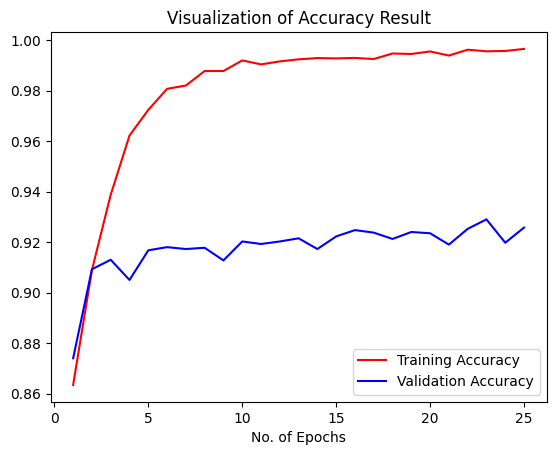

In [41]:
epochs = [i for i in range(1,26)]
plt.plot(epochs,hist.history['Accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,hist.history['val_Accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [46]:
class_indices = validation_generator.class_indices  # A dictionary: {'class_name': index}
class_names = list(class_indices.keys())  # Extract class names
print(class_names)


['Fractured', 'Non_fractured']


In [52]:
validation_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory='/kaggle/input/fractureclassification/fracture',
x_col="Images",
y_col="Labels",
subset='validation',
batch_size=8,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(288,288))

Found 4000 validated image filenames belonging to 2 classes.


In [54]:
y_pred = model.predict(validation_generator)
y_pred,y_pred.shape

500/500 [==============================] - 20s 41ms/step


(array([[3.0154640e-06, 9.9999702e-01],
        [2.4097119e-05, 9.9997592e-01],
        [1.5042011e-12, 1.0000000e+00],
        ...,
        [1.7657055e-07, 9.9999988e-01],
        [9.9941981e-01, 5.8019871e-04],
        [1.0000000e+00, 6.1710118e-14]], dtype=float32),
 (4000, 2))

In [56]:
predicted_categories = tf.argmax(y_pred, axis=1)

In [62]:
true_categories = []
for i in range(len(validation_generator)):  # Adjust the number 10 based on how many batches you want to process
    _, labels = validation_generator[i]
    true_categories.append(labels)

# Concatenate the labels
true_categories = tf.concat(true_categories, axis=0)

# Get the true class indices if labels are one-hot encoded
Y_true = tf.argmax(true_categories, axis=1)


In [63]:
Y_true

<tf.Tensor: shape=(4000,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 0])>

In [64]:
predicted_categories

<tf.Tensor: shape=(4000,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 0])>

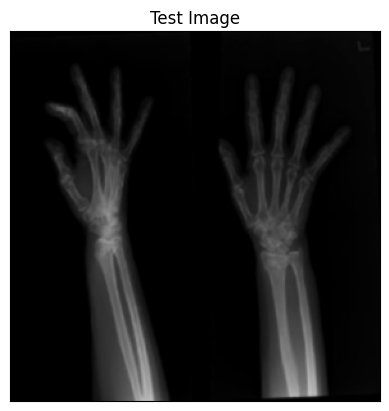

In [65]:
#Test Image Visualization
import cv2
image_path = '/kaggle/input/fractureclassification/fracture/Fractured/aug_00_IMG0000284.jpg'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image 
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [67]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(288,288))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

1/1 [==============================] - 0s 35ms/step


In [70]:
predictions

array([[0.9914425 , 0.00855753]], dtype=float32)

In [71]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

0


In [73]:
# Define class names (replace with your actual class names)
class_names = ['Fractured', 'Non_fractured']  # Ensure this matches the order of classes used in training

# Map index to class name
model_prediction = class_names[result_index]

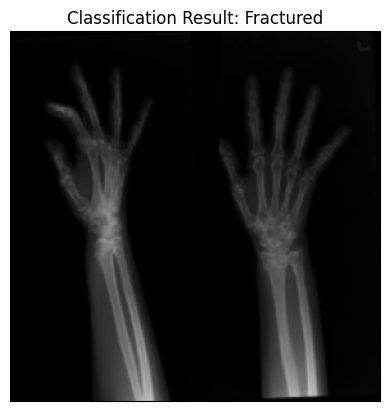

In [75]:
# Displaying the disease prediction
model_prediction = class_names[result_index]
plt.imshow(img)
plt.title(f"Classification Result: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()